In [1]:
from torchvision import transforms as tt
from torchvision.datasets import ImageFolder
from  torch.utils.data import DataLoader, random_split, ConcatDataset

from torch import nn
import torch
import torch.optim as optim

from PKLotDetector import PKLotDetector

import matplotlib.pyplot as plt
import random

----
First Dataset

In [2]:
transforms = tt.Compose([tt.Resize((100, 100)),
                            #     tt.RandomRotation(degrees=30),        # Случайные повороты до 30 градусов
                                tt.RandomHorizontalFlip(p=0.5),       # Случайные горизонтальные отражения
                                tt.RandomVerticalFlip(p=0.5),         # Случайные вертикальные отражения
                                tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                         tt.ToTensor()])

In [3]:
first_folder_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Data/FIRST DATASET/CROPPED"
second_folder_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Data/SECOND DATASET/CROPPED"
third_folder_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Data/THIRD DATASET/CROPPED"
fourth_folder_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Data/FOURTH DATASET/CROPPED"
fifth_folder_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Data/FIFTH DATASET/CROPPED"
sixth_folder_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Data/SIXTH DATASET/CROPPED"
seventh_folder_path = "/Users/osiprovin/Desktop/ml:dl/CV/Parking detection/Data/SEVENTH DATASET/CROPPED"


folder_paths = [first_folder_path, second_folder_path, third_folder_path, fourth_folder_path, fifth_folder_path, sixth_folder_path, seventh_folder_path]

In [4]:
# # 3 diffrenet angles -> 3k for each angle -> 9k
# first_train_samples = 9000
# first_val_samples = 724

# # all images different angle -> use all
# second_train_samples = 5484
# second_val_samples = 724

# # all images different angle -> use all
# third_train_samples = 8028
# third_val_samples = 724

# # 9 diffrenet angles -> 3k for each angle -> 27k
# fourth_train_samples = 27000
# fourth_val_samples = 724

# # all images different angle -> use all
# fifth_train_samples = 2300
# fifth_val_samples = 724

# sixth_train_samples = 5000
# sixth_val_samples = 724

# seventh_train_samples = 10000
# seventh_val_samples = 724

In [5]:
# 3 diffrenet angles -> 3k for each angle -> 9k
first_train_samples = 13000
first_val_samples = 724

# all images different angle -> use all
second_train_samples = 5484
second_val_samples = 724

# all images different angle -> use all
third_train_samples = 8028
third_val_samples = 724

# 9 diffrenet angles -> 3k for each angle -> 27k
fourth_train_samples = 33000
fourth_val_samples = 724

# all images different angle -> use all
fifth_train_samples = 2300
fifth_val_samples = 724

sixth_train_samples = 10000
sixth_val_samples = 724

seventh_train_samples = 10000
seventh_val_samples = 724



samples = {"train": [first_train_samples, second_train_samples, third_train_samples, fourth_train_samples, fifth_train_samples, sixth_train_samples, seventh_train_samples],
           "val": [first_val_samples, second_val_samples, third_val_samples, fourth_val_samples, fifth_val_samples, sixth_val_samples, seventh_val_samples]}

In [6]:
def get_sampled_train_val(data_dir, transforms, train_samples, val_samples):
    dataset = ImageFolder(root=data_dir, transform=transforms)
    train_dataset, rest_part_dataset = random_split(dataset, [train_samples, len(dataset) - train_samples])
    val_dataset, _ = random_split(rest_part_dataset, [val_samples, len(rest_part_dataset) - val_samples])
    return train_dataset, val_dataset

In [7]:
train_folders = []
val_folders = []

for idx in range(len(folder_paths)):
    train_folder, val_folder = get_sampled_train_val(folder_paths[idx], transforms, samples["train"][idx], samples["val"][idx])
    
    train_folders.append(train_folder)
    val_folders.append(val_folder)

In [8]:
train_folder = ConcatDataset(train_folders)
val_folder = ConcatDataset(val_folders)

In [9]:
batch_size = 4
train_loader = DataLoader(train_folder, shuffle=True, drop_last=True, batch_size=batch_size)
val_loader = DataLoader(val_folder, shuffle=True, drop_last=True, batch_size=batch_size)

In [10]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

pklot_detector = PKLotDetector().to(device)

criterion = nn.BCELoss().to(device)

optimizer = optim.Adam(pklot_detector.parameters(), lr=3e-4)

num_epochs = 2

In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    
    # Train
    pklot_detector.train()
    train_loss = 0.0
    correct_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        outputs = pklot_detector(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_folder)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / len(train_folder)
    train_accuracies.append(train_accuracy)
    

    
    # Validation
    pklot_detector.eval() 
    val_loss = 0.0
    correct_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            outputs = pklot_detector(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
    
    val_loss /= len(val_folder)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / len(val_folder)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}, Training Loss: {round(train_loss, 5)}, Training Accuracy: {round(train_accuracy, 2)}%, Validation Loss: {round(val_loss, 5)}, Validation Accuracy: {round(val_accuracy, 2)}%")



torch.save(pklot_detector.state_dict(), 'pklot_detector.pth')

Epoch 1, Training Loss: 0.05746, Training Accuracy: 91.27%, Validation Loss: 0.03779, Validation Accuracy: 93.69%


In [ ]:
def get_accuracy(loader, pklot_detector):
    correct_val = 0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = labels.float()
            outputs = pklot_detector(inputs).squeeze(1)
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item() / len(labels)

    accuracy = correct_val / len(loader)

    return accuracy

In [ ]:
pklot_detector = pklot_detector.cpu()
loaders = [DataLoader(folder, shuffle=True, drop_last=True, batch_size=batch_size) for folder in val_folders]
accuracys = [get_accuracy(loader, pklot_detector) for loader in loaders]
accuracys

[0.9129834254143646,
 0.9903314917127072,
 0.9875690607734806,
 0.9475138121546961,
 0.9502762430939227,
 0.9958563535911602]

without 6 dataset: 
[0.9129834254143646,
 0.9875690607734806,
 0.9875690607734806,
 0.9488950276243094,
 0.9765193370165746] -- 15 incorrect in test

with 6 dataset(4k):
[0.9544198895027625,
 0.988950276243094,
 0.9834254143646409,
 0.9406077348066298,
 0.9696132596685083,
 0.8024861878453039] -- 9 incorrect in test

with 6 dataset(6k):
[0.9392265193370166,
 0.9875690607734806,
 0.9585635359116023,
 0.9392265193370166,
 0.9447513812154696,
 0.8314917127071824]

with 6 rotated dataset(5k):
[0.8770718232044199,
 0.9848066298342542,
 0.9972375690607734,
 0.9530386740331491,
 0.9861878453038674,
 0.824585635359116] -- 9

 with 7(10k) without 6:
 [0.9129834254143646,
 0.9903314917127072,
 0.9875690607734806,
 0.9475138121546961,
 0.9502762430939227,
 0.9958563535911602]

In [ ]:
def plot_single_metric(metric_values, metric_name):
    epochs = range(1, len(metric_values) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metric_values)
    plt.title(f'{metric_name} over epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

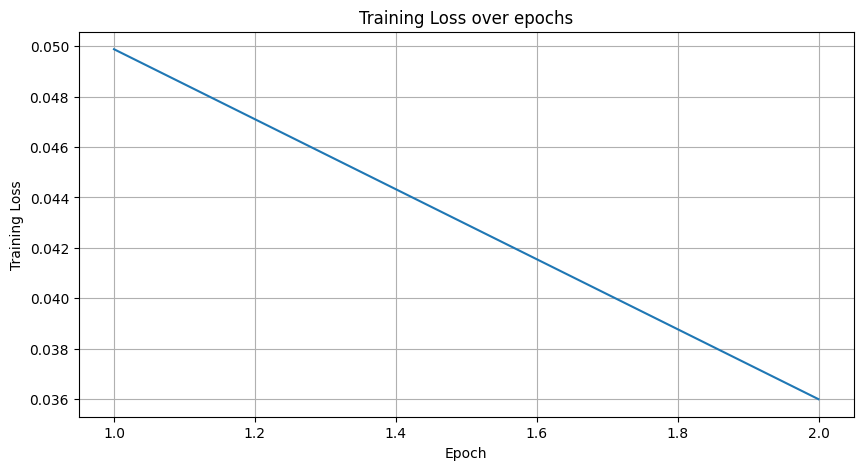

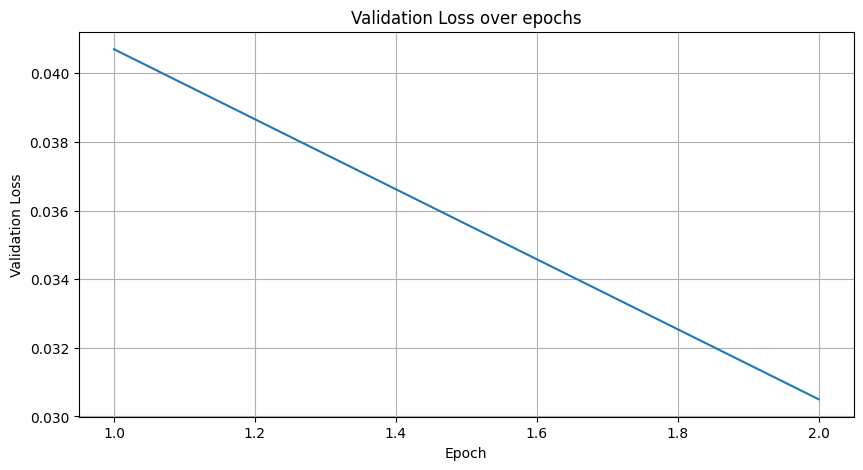

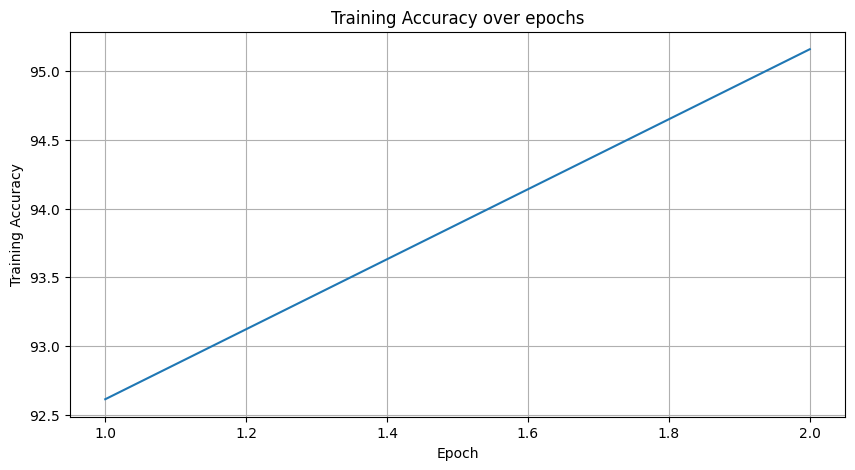

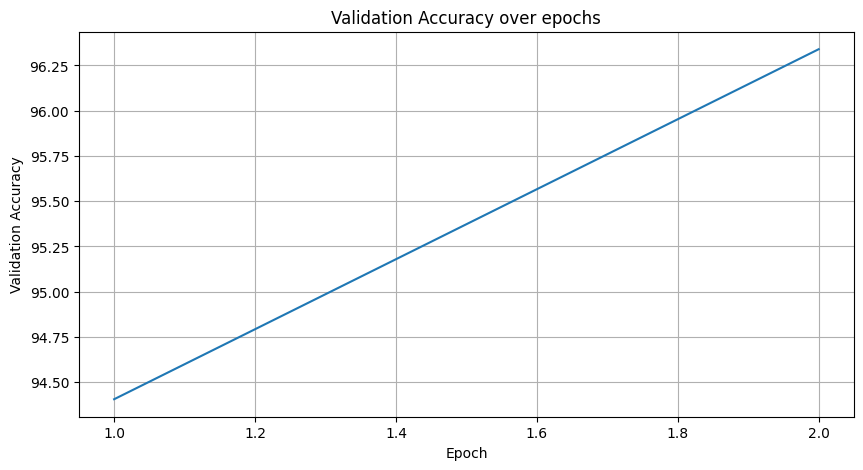

In [ ]:
all_metrics = [train_losses, val_losses, train_accuracies, val_accuracies]
metric_names = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']

for metric_values, metric_name in zip(all_metrics, metric_names):
    plot_single_metric(metric_values, metric_name)